In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import os

LOADING DATA

In [2]:
train = pd.read_csv('csvTrainImages 13440x1024.csv', header = None).values
train_target = pd.read_csv('csvTrainLabel 13440x1.csv', header = None)
test = pd.read_csv('csvTestImages 3360x1024.csv', header = None).values
test_target = pd.read_csv('csvTestLabel 3360x1.csv', header = None)

In [3]:
train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
train_target

,0
0,1
1,1
2,1
3,1
4,1
...,...
13435,28
13436,28
13437,28
13438,28


In [5]:
train.shape

(13440, 1024)

In [6]:
train_target.shape

(13440, 1)

In [7]:
test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
test_target

,0
0,1
1,1
2,2
3,2
4,3
...,...
3355,26
3356,27
3357,27
3358,28


In [9]:
test.shape

(3360, 1024)

In [10]:
test_target

,0
0,1
1,1
2,2
3,2
4,3
...,...
3355,26
3356,27
3357,27
3358,28


In [11]:
test_target.shape

(3360, 1)

In [12]:
train_target = train_target.squeeze()
test_target = test_target.squeeze()

In [13]:
train_target

0         1
1         1
2         1
3         1
4         1
         ..
13435    28
13436    28
13437    28
13438    28
13439    28
Name: 0, Length: 13440, dtype: int64

In [14]:
test_target

0        1
1        1
2        2
3        2
4        3
        ..
3355    26
3356    27
3357    27
3358    28
3359    28
Name: 0, Length: 3360, dtype: int64

IDENTIFY TARGETS

In [15]:
letters = ["ا","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
letters_dict = dict(zip(np.arange(1,len(letters)+1), letters))

In [16]:
print(letters_dict)

{1: 'ا', 2: 'ب', 3: 'ت', 4: 'ث', 5: 'ج', 6: 'ح', 7: 'خ', 8: 'د', 9: 'ذ', 10: 'ر', 11: 'ز', 12: 'س', 13: 'ش', 14: 'ص', 15: 'ض', 16: 'ط', 17: 'ظ', 18: 'ع', 19: 'غ', 20: 'ف', 21: 'ق', 22: 'ك', 23: 'ل', 24: 'م', 25: 'ن', 26: 'ه', 27: 'و', 28: 'ي'}


In [17]:
train_target = train_target.map(letters_dict).values
test_target = test_target.map(letters_dict).values

In [18]:
train_target

array(['ا', 'ا', 'ا', ..., 'ي', 'ي', 'ي'], dtype=object)

In [19]:
test_target

array(['ا', 'ا', 'ب', ..., 'و', 'ي', 'ي'], dtype=object)

In [20]:
train_target.shape

(13440,)

In [21]:
test_target.shape

(3360,)

RESHAPING DATA

In [22]:
x_train = (train).reshape(-1,32,32,1)
x_test = (test).reshape(-1,32,32,1)

In [23]:
train.shape

(13440, 1024)

In [24]:
test.shape

(3360, 1024)

In [25]:
x_train.shape

(13440, 32, 32, 1)

In [26]:
x_test.shape

(3360, 32, 32, 1)

In [27]:
x_train,train_target = shuffle(x_train,train_target)
x_test,test_target = shuffle(x_test,test_target)

In [28]:
x_train.shape

(13440, 32, 32, 1)

In [29]:
train_target.shape

(13440,)

In [30]:
x_test.shape

(3360, 32, 32, 1)

In [31]:
test_target.shape

(3360,)

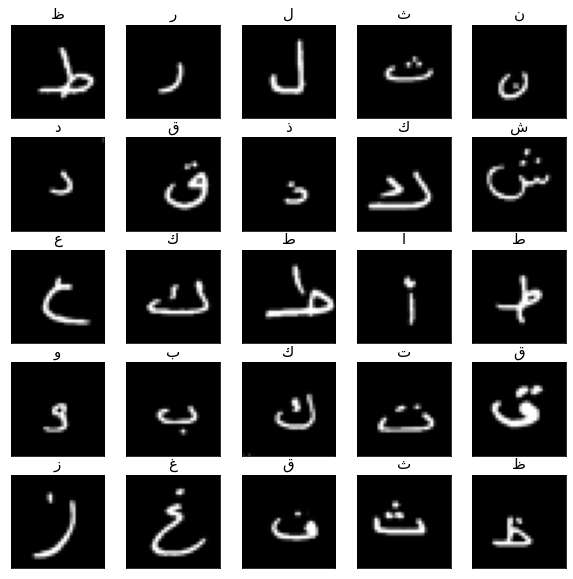

In [32]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(32,32).T,"gray")
    plt.title(train_target[i][0],fontsize = 15)
plt.show()

In [33]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_target = lb.fit_transform(train_target)
test_target = lb.fit_transform(test_target)

In [34]:
train_target.shape

(13440,)

In [35]:
test_target.shape

(3360,)

PREPARING OUR TRAINING MODEL

In [36]:
traingenerator=ImageDataGenerator(
    zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=traingenerator.flow(
    x_train ,train_target ,batch_size=64
)

testgenerator=ImageDataGenerator(rescale=1/255)
test_generator=testgenerator.flow(
    x_test ,test_target ,batch_size=64
 
)

In [37]:
earlystop=EarlyStopping(patience=6)
learning_rate=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate]

In [38]:
model=Sequential() 

model.add(Conv2D(32,(5,5), padding="same",activation='relu',input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), padding="same",activation='relu'))
model.add(Conv2D(32,(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(28,activation='softmax'))

In [39]:
model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

TRAINING OUR MODEL

In [56]:
model.fit(
    train_generator, 
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50
210/210 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9301

210/210 [==============================] - 7s 31ms/step - loss: 0.2319 - accuracy: 0.9301 - val_loss: 0.1281 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 2/50
209/210 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9270

210/210 [==============================] - 7s 31ms/step - loss: 0.2324 - accuracy: 0.9271 - val_loss: 0.1356 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/50
209/210 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9284

210/210 [==============================] - 6s 31ms/step - loss: 0.2301 - accuracy: 0.9283 - val_loss: 0.1334 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 4/50
209/210 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9325

210/210 [==============================] - 7s 31ms/step - loss: 0.2298 - accuracy: 0.9322 - val_loss: 0.1495 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 5/50
209/210 [============================>.] - ETA: 0s - loss: 0.2279 - accuracy: 0.9308

210/210 [==============================] - 7s 32ms/step - loss: 0.2285 - accuracy: 0.9307 - val_loss: 0.1287 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 6/50
209/210 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9299

210/210 [==============================] - 7s 32ms/step - loss: 0.2209 - accuracy: 0.9300 - val_loss: 0.1517 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 7/50
209/210 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9349

210/210 [==============================] - 7s 31ms/step - loss: 0.2116 - accuracy: 0.9349 - val_loss: 0.1427 - val_accuracy: 0.9601 - lr: 0.0010


EVALUATING

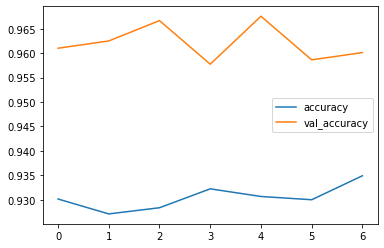

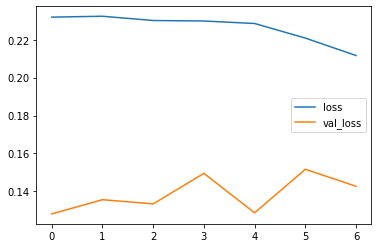

In [57]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy','val_accuracy']].plot()
metrics[['loss','val_loss']].plot()

In [58]:
model.evaluate(test_generator)

53/53 [==============================] - 0s 6ms/step - loss: 0.1427 - accuracy: 0.9601


[0.1427089124917984, 0.9601190686225891]

TESTING OUR MODEL WITH THE TEST DATA AND PREDICT RESULT

In [59]:
predictions = model.predict(x_test)
classes = np.argmax(predictions, axis=1)

105/105 [==============================] - 0s 2ms/step


In [60]:
test_target.shape

(3360,)

In [61]:
classes.shape

(3360,)

In [62]:
print(test_target)
print('\n')
print(classes)

[ 1 12 22 ... 14 17  6]


[ 1 12 22 ... 14 17  6]


SHOWING THE PREDICTED RESULTS

Text(0.5, 1.0, 'ض')

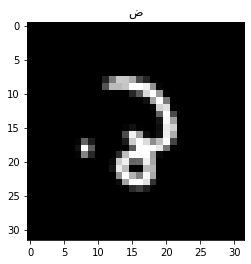

In [63]:
plt.imshow(x_test[22].reshape(32,32),"gray")
plt.title(letters[classes[22]])